Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [16]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels])
    )
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases
    )
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [1]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [17]:
%%time
num_steps = 801

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print(
                'Training accuracy: %.1f%%' % accuracy(
                    predictions, train_labels[:train_subset, :]
                )
            )
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print(
                'Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels
                )
            )
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 15.375020
Training accuracy: 11.8%
Validation accuracy: 15.8%
Loss at step 100: 2.272343
Training accuracy: 72.5%
Validation accuracy: 70.5%
Loss at step 200: 1.833306
Training accuracy: 75.7%
Validation accuracy: 73.1%
Loss at step 300: 1.604219
Training accuracy: 76.8%
Validation accuracy: 73.7%
Loss at step 400: 1.446131
Training accuracy: 77.7%
Validation accuracy: 74.2%
Loss at step 500: 1.326815
Training accuracy: 78.4%
Validation accuracy: 74.5%
Loss at step 600: 1.232527
Training accuracy: 78.9%
Validation accuracy: 74.8%
Loss at step 700: 1.155618
Training accuracy: 79.3%
Validation accuracy: 74.9%
Loss at step 800: 1.091265
Training accuracy: 79.8%
Validation accuracy: 74.9%
Test accuracy: 83.0%
CPU times: user 1min 37s, sys: 10.3 s, total: 1min 47s
Wall time: 38.2 s


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [18]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels])
    )
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [19]:
%%time
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict
        )
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print(
                "Validation accuracy: %.1f%%" % accuracy(
                    valid_prediction.eval(), valid_labels
                )
            )
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 14.944733
Minibatch accuracy: 15.6%
Validation accuracy: 17.8%
Minibatch loss at step 500: 1.899471
Minibatch accuracy: 77.3%
Validation accuracy: 75.7%
Minibatch loss at step 1000: 0.923517
Minibatch accuracy: 82.0%
Validation accuracy: 76.7%
Minibatch loss at step 1500: 0.889903
Minibatch accuracy: 82.0%
Validation accuracy: 77.7%
Minibatch loss at step 2000: 1.641797
Minibatch accuracy: 70.3%
Validation accuracy: 77.7%
Minibatch loss at step 2500: 0.724198
Minibatch accuracy: 81.2%
Validation accuracy: 78.6%
Minibatch loss at step 3000: 1.107124
Minibatch accuracy: 75.0%
Validation accuracy: 78.2%
Test accuracy: 85.6%
CPU times: user 6.65 s, sys: 785 ms, total: 7.44 s
Wall time: 4.21 s


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [5]:
batch_size = 128
num_hidden_neurons = 512

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # relu hidden layer
    with tf.name_scope('hidden1'):
        # Variables.
        weights = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden_neurons])
        )
        biases = tf.Variable(tf.zeros([num_hidden_neurons]))
        hidden_dict = {"weights": weights, "biases": biases}
#         hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    
    with tf.name_scope('logits'):
        # Variables.
        weights = tf.Variable(
            tf.truncated_normal([num_hidden_neurons, num_labels])
        )
        biases = tf.Variable(tf.zeros([num_labels]))
        logits_dict = {"weights": weights, "biases": biases}
#         logits = tf.matmul(hidden1, weights) + biases

    def forward_prop(X):
        h = tf.nn.relu(tf.matmul(X, hidden_dict['weights']) + hidden_dict['biases'])
        return tf.matmul(h, logits_dict['weights']) + logits_dict['biases']
    
    # Training computation.
#     logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(forward_prop(tf_train_dataset), tf_train_labels)
    )

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(forward_prop(tf_train_dataset))
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Let's run it:

In [6]:
import tqdm

In [7]:
%%time
num_steps = 100001

losses = []
acc = []
valid_acc = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in tqdm.trange(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict
        )
        if (step % 100 == 0):
            losses.append(l)
            acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
#         if (step % 1000 == 0):
#             print("Minibatch loss at step %d: %f" % (step, l))
#             print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#             print(
#                 "Validation accuracy: %.1f%%" % accuracy(
#                     valid_prediction.eval(), valid_labels
#                 )
#             )
            
#     print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

  0%|          | 0/100001 [00:00<?, ?it/s]

Initialized


100%|██████████| 100001/100001 [20:44<00:00, 80.35it/s]0%|          | 8/100001 [00:00<8:36:08,  3.23it/s] 

CPU times: user 1h 6min 52s, sys: 1min 38s, total: 1h 8min 30s
Wall time: 20min 44s


In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/alexis/anaconda3/envs/dnn/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['step', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
import ggplot
from pandas import DataFrame
import pandas as pd

In [25]:
df = DataFrame({'loss': losses, "accuracy": acc, "valid accuracy": valid_acc})
df.index = np.arange(0, num_steps, 100)
df.index.name = 'step'

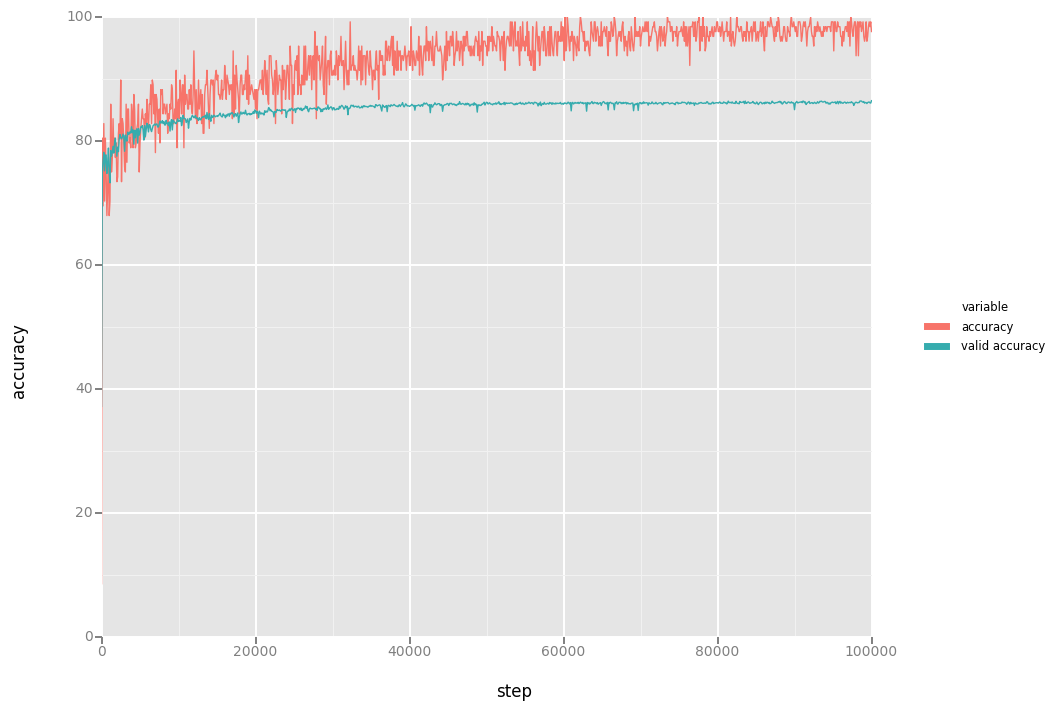

<ggplot: (312971086)>

In [47]:
ggplot.ggplot(
    ggplot.aes('step', 'accuracy', 'variable'), 
    pd.melt(df.reset_index(), value_vars=['accuracy', 'valid accuracy'], id_vars='step', value_name='accuracy')
) + ggplot.geom_line()

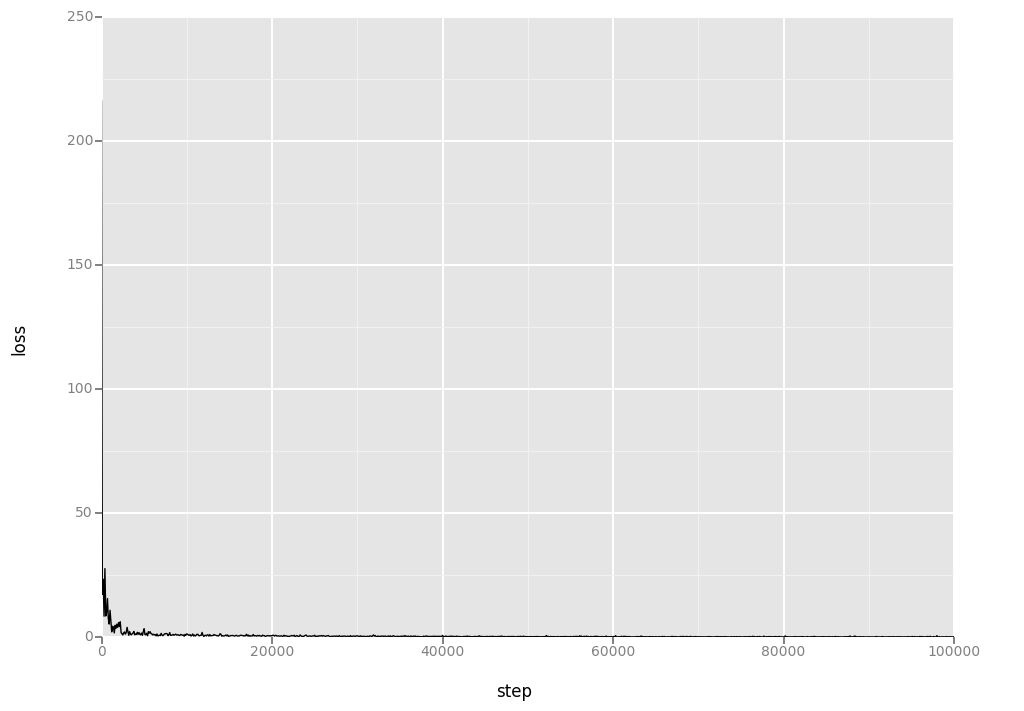

<ggplot: (306545686)>

In [43]:
ggplot.ggplot(ggplot.aes('step', 'loss'), data=df.reset_index()) + ggplot.geom_line()